In [16]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import os, os.path
import keras
import time
import scipy.misc
import scipy.ndimage

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import CSVLogger
from keras import backend as K
from keras.initializers import RandomUniform, RandomNormal

from PIL import Image

from tqdm import tqdm
from datetime import datetime

%matplotlib inline

In [2]:
# resolution of images

x = 75
y = 100

In [3]:
#Creates list of positiv files
positiv_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Sep17/pos/IMG_*.png')
#Finds the number of positiv files
positiv_len = len(positiv_list)
print("Size of positiv Sample: {}".format(positiv_len))

#Same but for negativ files
negativ_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Sep17/neg/IMG_*.png')
negativ_len = len(negativ_list)
print("Size of negativ Sample: {}".format(negativ_len))

Size of positiv Sample: 27146
Size of negativ Sample: 12110


In [4]:
X_posind = []
X_negind = []
X_posinu = []
X_neginu = []
X_posinl = []
X_neginl = []
X_posinr = []
X_neginr = []

X_pos = []
X_neg = []

for fname in tqdm(positiv_list):
    img = scipy.misc.imresize(np.array(Image.open(fname)),(x,y))
    
    #X_posind.append(scipy.ndimage.interpolation.shift(img, (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    #X_posinu.append(scipy.ndimage.interpolation.shift(img, (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    
    #X_posinr.append(scipy.ndimage.interpolation.shift(img, (0,50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    #X_posinl.append(scipy.ndimage.interpolation.shift(img, (0,-50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    
    X_pos.append(img) 
    
#Shuffling the order of the negtive images - required to avoid batches selecting similar images
np.random.shuffle(negativ_list)   
    
for fname in tqdm(negativ_list):
    img = scipy.misc.imresize(np.array(Image.open(fname)),(x,y))
    
    #X_negind.append(scipy.ndimage.interpolation.shift(img, (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    #X_neginu.append(scipy.ndimage.interpolation.shift(img, (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    
    #X_neginr.append(scipy.ndimage.interpolation.shift(img, (0,50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    #X_neginl.append(scipy.ndimage.interpolation.shift(img, (0,-50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    
    X_neg.append(img)

100%|██████████| 12110/12110 [00:21<00:00, 553.75it/s]


In [5]:
X_posind = np.array(X_posind)
X_negind = np.array(X_negind)
X_posinu = np.array(X_posinu)
X_neginu = np.array(X_neginu)
X_posinl = np.array(X_posinl)
X_neginl = np.array(X_neginl)
X_posinr = np.array(X_posinr)
X_neginr = np.array(X_neginr)
X_pos = np.array(X_pos)
X_neg = np.array(X_neg)

In [6]:
X_all = np.concatenate((X_pos, X_neg), axis=0)
Y_all = np_utils.to_categorical(np.concatenate(( np.zeros((negativ_len,1)), np.ones((positiv_len, 1)) ), axis=0), 2)
#X_all_trans = np.concatenate((X_pos, X_posind, X_posinu, X_posinl, X_posinr, X_neg, X_negind, X_neginu, X_neginl, X_neginr), axis=0)
#Y_all_trans = np_utils.to_categorical(np.concatenate((np.ones((5*positiv_len, 1)), np.zeros((5*negativ_len,1))), axis=0), 2)

In [7]:
X_all.shape

(39256, 75, 100)

In [8]:
Y_all.shape

(39256, 2)

In [9]:
#Shuffling the order of the input - required to avoid batches selecting only positive/negative images
randomize = np.arange(len(X_all))
np.random.shuffle(randomize)
X_all = X_all[randomize]
Y_all = Y_all[randomize]

In [10]:
# Hold 5% back as training data
train_split = int(0.05 * len(X_all))

# Separate in Training and Testing Sample
X_train = X_all[train_split:]
Y_train = Y_all[train_split:]

X_test = X_all[:train_split]
Y_test = Y_all[:train_split]

In [11]:
X_train = X_train.reshape(X_train.shape[0], x, y, 1)
X_test = X_test.reshape(X_test.shape[0], x, y, 1)

#Shape check (NumberofImages, Height, Width, Depth)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(37294, 75, 100, 1)
(37294, 2)
(1962, 75, 100, 1)
(1962, 2)


### Test with lower resolution

In [27]:
x_new = 30
y_new = 40

In [28]:
X_all_30_40 = []
for img in X_all:
    X_all_30_40.append(scipy.misc.imresize(np.array(img),(x_new,y_new)))
    
X_all_30_40 = np.array(X_all_30_40)
Y_all_30_40 = Y_all

In [29]:
#Shuffling the order of the input - required to avoid batches selecting only positive/negative images
randomize = np.arange(len(X_all))
np.random.shuffle(randomize)
X_all_30_40 = X_all_30_40[randomize]
Y_all_30_40 = Y_all_30_40[randomize]

In [30]:
# Hold 5% back as training data
train_split = int(0.05 * len(X_all_30_40))

# Separate in Training and Testing Sample
X_train_30_40 = X_all_30_40[train_split:]
Y_train_30_40 = Y_all_30_40[train_split:]

X_test_30_40 = X_all_30_40[:train_split]
Y_test_30_40 = Y_all_30_40[:train_split]

In [31]:
X_train_30_40 = X_train_30_40.reshape(X_train_30_40.shape[0], x_new, y_new, 1)
X_test_30_40 = X_test_30_40.reshape(X_test_30_40.shape[0], x_new, y_new, 1)

# Data need to be normalised
* Mean and StdDev for each pixel over whole data set

In [12]:
X_train.shape

(37294, 75, 100, 1)

In [13]:
means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)

#means_30_40 = np.mean(X_train_30_40, axis=0)
#stds_30_40 = np.std(X_train_30_40, axis=0)

In [14]:
print(means.shape)
print(stds.shape)
#print(means_30_40.shape)
#print(stds_30_40.shape)

(75, 100, 1)
(75, 100, 1)


In [17]:
path_meanstd = '../TrainedModels/' + str(datetime.now().strftime('%Y-%m-%d')) + '/MeansStdDev/'

if not os.path.exists(path_meanstd):
    os.makedirs(path_meanstd)
    print('Created path: {}'.format(path_meanstd))
                                            
#np.savetxt('../Data/Means_30_40.txt', means_30_40)
#np.savetxt('../Data/StdDev_30_40.txt', stds_30_40)
np.savetxt(path_meanstd +'Means_' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) +  '.txt', means)
np.savetxt(path_meanstd +'StdDev_' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) +  '.txt', stds)

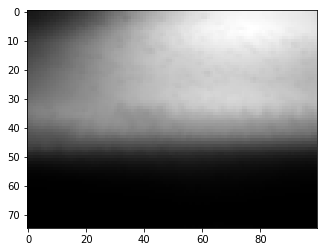

In [18]:
plt.imshow(np.squeeze(means), cmap='gray')
plt.savefig(path_meanstd + 'MeanImg' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.png')

In [19]:
X_train_norm = np.array([(img-means)/stds for img in X_train])
X_test_norm = np.array([(img-means)/stds for img in X_test])

In [20]:
#X_train_30_40_norm = np.array([(img-means_30_40)/stds_30_40 for img in X_train_30_40])
#X_test_30_40_norm = np.array([(img-means_30_40)/stds_30_40 for img in X_test_30_40])

# Let the training begin...

In [21]:
## Class to get loss and accuracy during training of NN

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))

In [22]:
input_shape= (x,y,1)
#input_shape_30_40= (x_new,y_new,1)

seed = 1234

* initializer need to have mean = 0 and std 1/input_shape
* for successive layers output shape of previous layer will declare this

In [23]:
model = Sequential()

# First Convolutional layer initialised with random input weights
model.add(Conv2D(32, (11,11), kernel_initializer=RandomNormal(mean=0, stddev=1/(x*y)), padding='valid', input_shape=input_shape, activation='selu'))
model.add(MaxPooling2D(pool_size=(2,2)))

mult_shape1 = model.layers[1].output_shape[1]*model.layers[1].output_shape[2]*model.layers[1].output_shape[3]

# Second Convolutional layer
model.add(Conv2D(32, (11,11), kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape1), padding='valid', activation='selu'))
model.add(MaxPooling2D(pool_size=(2,2)))

mult_shape2 = model.layers[3].output_shape[1]*model.layers[3].output_shape[2]*model.layers[3].output_shape[3]

# Third Convolutional layer
model.add(Conv2D(32, (9,9), kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape2), padding='valid', activation='selu'))
model.add(MaxPooling2D(pool_size=(2,2)))


#Converting the 2D images to 1D vectors
model.add(Flatten())  

# First Fully connected layer
model.add(Dense(32, activation='selu'))
model.add(Dropout(0.2))

#Second Fully connected layer
model.add(Dense(32, activation='selu'))
model.add(Dropout(0.2))

#Output layer
model.add(Dense(2, activation='softmax'))


In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 65, 90, 32)        3904      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 35, 32)        123936    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 9, 32)          82976     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

In [ ]:
#Defining optimiser and compiling the model

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])
        
history = LossHistory()
model.fit(X_train_norm, Y_train,  batch_size=32, epochs=24, verbose=1, validation_split = 0.1, callbacks=[history])

#Evaluating trained model on test images
score = model.evaluate(X_test_norm, Y_test, verbose=0)
print('Model has accuracy:', score[1]*100,'%')

Train on 33564 samples, validate on 3730 samples
Epoch 1/24
27136/33564 [=======================>......] - ETA: 44s - loss: 0.7221 - acc: 0.6466

In [ ]:
#To save trained NN - USE DIFFERENT NAME FOR NEW NETWORK
model.save(path_model + '3211_3211_329_32_32_selu_24epochs.h5')

In [ ]:
np.savetxt(path_model + '3211_3211_329_32_32_selu_24epochs_TrainingData.txt', np.transpose([history.accuracy, history.losses]))

In [ ]:
accuracy = np.array(history.accuracy)
losses = np.array(history.losses)

fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(accuracy, color = 'b', marker='', ls='-')
ax[1].plot(losses, color = 'm', marker='', ls='-')

ax[1].set_xlabel('batch number')
ax[0].set_ylabel('accuracy')
ax[1].set_ylabel('loss')
#ax[1].set_yscale('log')

#### Score Distributions

In [ ]:
probs = []

for img in X_test_norm:
    img = np.reshape(img, [1,x,y,1])
    p = test_model.predict_proba(img, verbose=0)
    probs.append(np.squeeze(p))
    
probs = np.array(probs) 

# Score
true = []
false = []
for p, t in zip(probs[:,0], Y_test[:,0]):
    if t == 1:
        true.append(p)
    if t == 0:
        false.append(p)
        
true = np.array(true)
false = np.array(false)

In [ ]:
fig, ax = plt.subplots()

ax.hist(false, bins=np.arange(0, 1 + 0.05, 0.05), histtype='stepfilled', linewidth=1, edgecolor='m', color='#ff99ff', alpha=1, label='neg img')
ax.hist(true, bins=np.arange(0, 1 + 0.05, 0.05), histtype='stepfilled', linewidth=1, edgecolor='b', color='#6666ff', alpha=1, label='pos img')

ax.hist(false, bins=np.arange(0, 1 + 0.05, 0.05), histtype='step', linewidth=1, linestyle='-', edgecolor='m', color='c', alpha=1)
ax.hist(true, bins=np.arange(0, 1 + 0.05, 0.05), histtype='step', linewidth=1, linestyle='-',edgecolor='b', color='b', alpha=1)

ax.set_yscale('log')

ax.legend(loc='best')

# Analyse saved model

In [57]:
test_model = load_model('../TrainedModels/1613_1611_169_32_32_relu_woDropout_240_epochs.h5')

In [60]:
#Evaluating trained model on test images
score = test_model.evaluate(X_test_norm, Y_test, verbose=0)
print('Model has accuracy:', score[1]*100,'%')

Model has accuracy: 99.6432212029 %


In [58]:
accuracy, losses = np.genfromtxt('../Data/TrainingsData/1613_1611_169_32_32_relu_woDropout_240_epochs_TrainingData.txt', unpack=True)

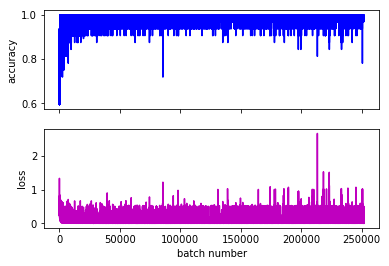

In [61]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(accuracy, color = 'b', marker='', ls='-')
ax[1].plot(losses, color = 'm', marker='', ls='-')

ax[1].set_xlabel('batch number')
ax[0].set_ylabel('accuracy')
ax[1].set_ylabel('loss')
#ax[1].set_yscale('log')

# Score distribution for models on testdata

In [81]:
test_model = load_model('../TrainedModels/')

In [82]:
probs = []

for img in X_test_norm:
    img = np.reshape(img, [1,x,y,1])
    p = test_model.predict_proba(img, verbose=0)
    probs.append(np.squeeze(p))
    
probs = np.array(probs)    

In [83]:
# Score
true = []
false = []
for p, t in zip(probs[:,0], Y_test[:,0]):
    if t == 1:
        true.append(p)
    if t == 0:
        false.append(p)
        
true = np.array(true)
false = np.array(false)

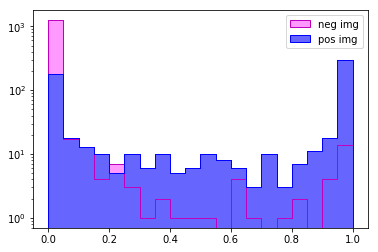

In [84]:
fig, ax = plt.subplots()

ax.hist(false, bins=np.arange(0, 1 + 0.05, 0.05), histtype='stepfilled', linewidth=1, edgecolor='m', color='#ff99ff', alpha=1, label='neg img')
ax.hist(true, bins=np.arange(0, 1 + 0.05, 0.05), histtype='stepfilled', linewidth=1, edgecolor='b', color='#6666ff', alpha=1, label='pos img')

ax.hist(false, bins=np.arange(0, 1 + 0.05, 0.05), histtype='step', linewidth=1, linestyle='-', edgecolor='m', color='c', alpha=1)
ax.hist(true, bins=np.arange(0, 1 + 0.05, 0.05), histtype='step', linewidth=1, linestyle='-',edgecolor='b', color='b', alpha=1)

ax.set_yscale('log')

ax.legend(loc='best')

In [170]:
X_test_norm.shape

(3199, 75, 100, 1)

In [169]:
mask = [t<=0.4 for t in true]
len(true[mask])

10

In [167]:
true[mask]

array([ 0.3108232 ,  0.561351  ,  0.35285813,  0.13598061,  0.22960733,
        0.36893725,  0.59845793,  0.439345  ,  0.4335185 ,  0.55695796,
        0.33551922,  0.18115899,  0.03894445,  0.31848711,  0.2846505 ,
        0.59369594,  0.43472007,  0.59333205], dtype=float32)

In [154]:
len(t < 0.4 for t in true)

(array([0]),)